# Sequence Generation

Generate new MIDI sequences using previously-trained **Doc2Vec** and **Keras** models.

## Imports

In [1]:
import sys
import logging
import json
import music21
import os
from music21 import converter
import ipywidgets as widgets

# Add Midi2Vec to Python working directory
sys.path.append('../')

from encoding import Encoder
from sequence_learning import GenerativeSequenceLearner, SequenceGenerator
from data_loading import MidiDataLoader
from midi_to_dataframe import NoteMapper, MidiWriter

Using TensorFlow backend.


## Logging Configuration

In [2]:
logger = logging.getLogger()
logger.level = logging.INFO
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

## Load Pre-Trained Models

In [3]:
model_path = "models/breakbeat/breakbeat_32epochs_2.9"
settings_path = model_path + "/settings.json"
encoder_path = model_path + "/encoder"
seq_path = model_path + "/seq.h5"

# Load model parameters
with open(settings_path) as f:
    model_params = json.load(f)
    
# Load Encoder (Doc2Vec)
encoder = Encoder(model_params)
encoder.load(encoder_path)

# Load SequenceLearner (Keras)
sequence_model = GenerativeSequenceLearner(model_params)
sequence_model.load(seq_path)

loading Doc2Vec object from models/breakbeat/breakbeat_32epochs_2.9/encoder
loading vocabulary recursively from models/breakbeat/breakbeat_32epochs_2.9/encoder.vocabulary.* with mmap=None
loading wv recursively from models/breakbeat/breakbeat_32epochs_2.9/encoder.wv.* with mmap=None
loading trainables recursively from models/breakbeat/breakbeat_32epochs_2.9/encoder.trainables.* with mmap=None
loading docvecs recursively from models/breakbeat/breakbeat_32epochs_2.9/encoder.docvecs.* with mmap=None
loading vectors_docs from models/breakbeat/breakbeat_32epochs_2.9/encoder.docvecs.vectors_docs.npy with mmap=None
loaded models/breakbeat/breakbeat_32epochs_2.9/encoder
Encoder loaded from: models/breakbeat/breakbeat_32epochs_2.9/encoder
SequenceLearner loaded from: models/breakbeat/breakbeat_32epochs_2.9/seq.h5


## Define Seed Sequences

In [4]:
system_shock = ["../resources/midi/system_shock/cyberspace_clip_16.mid",
                "../resources/midi/system_shock/end_remix_clip_16.mid",
                "../resources/midi/system_shock/energy_clip_16.mid",
                "../resources/midi/system_shock/security_bridge_clip_16.mid"]

breakbeats = ["../resources/midi/breakbeats/084 Breakthru.mid",
             "../resources/midi/breakbeats/086 Clouds.mid",
             "../resources/midi/breakbeats/089 Get Out.mid",
             "../resources/midi/breakbeats/089 Wrong.mid",
             "../resources/midi/breakbeats/090 Deceive.mid",
             "../resources/midi/breakbeats/090 New York.mid",
             "../resources/midi/breakbeats/090 Radio.mid",
             "../resources/midi/breakbeats/093 Pretender.mid",
             "../resources/midi/breakbeats/093 Right Won.mid",
             "../resources/midi/breakbeats/094 Run.mid"]

jungle = ["../resources/midi/jungle/160 Jungle 05.mid",
          "../resources/midi/jungle/160 Jungle 11.mid",
          "../resources/midi/jungle/170 Jungle 01.mid",
          "../resources/midi/jungle/170 Jungle 03.mid",
          "../resources/midi/jungle/170 Jungle 04.mid",
          "../resources/midi/jungle/170 Jungle 06.mid",
          "../resources/midi/jungle/170 Jungle 07.mid",
          "../resources/midi/jungle/170 Jungle 08.mid",
          "../resources/midi/jungle/170 Jungle 09.mid",
          "../resources/midi/jungle/170 Jungle 10.mid",
          "../resources/midi/jungle/170 Jungle 12.mid",
          "../resources/midi/jungle/170 Jungle 13.mid",
          "../resources/midi/jungle/170 Jungle 14.mid",
          "../resources/midi/jungle/170 Jungle 15.mid",
          "../resources/midi/jungle/170 Jungle 16.mid",
          "../resources/midi/jungle/180 Jungle 02.mid"]

bach_chorales = ["../resources/midi/bach_chorales/01-AchGottundHerr.mid",
                 "../resources/midi/bach_chorales/02-AchLiebenChristen.mid",
                 "../resources/midi/bach_chorales/03-ChristederdubistTagundLicht.mid",
                 "../resources/midi/bach_chorales/04-ChristeDuBeistand.mid",
                 "../resources/midi/bach_chorales/05-DieNacht.mid",
                 "../resources/midi/bach_chorales/06-DieSonne.mid",
                 "../resources/midi/bach_chorales/07-HerrGott.mid",
                 "../resources/midi/bach_chorales/08-FuerDeinenThron.mid",
                 "../resources/midi/bach_chorales/09-Jesus.mid",
                 "../resources/midi/bach_chorales/10-NunBitten.mid"]

post_metal = ["../resources/midi/post_metal/isis_carry-01.mid",
              "../resources/midi/post_metal/isis_carry-02.mid",
              "../resources/midi/post_metal/isis_carry-03.mid",
              "../resources/midi/post_metal/isis_from-sinking-01.mid",
              "../resources/midi/post_metal/isis_from-sinking-02.mid",
              "../resources/midi/post_metal/isis_in-fiction-02.mid",
              "../resources/midi/post_metal/isis_in-fiction-03.mid",
              "../resources/midi/post_metal/isis_in-fiction-05.mid",
              "../resources/midi/post_metal/isis_pliable-foe-01.mid",
              "../resources/midi/post_metal/isis_the-beginning-and-the-end-01.mid",
              "../resources/midi/post_metal/isis_the-beginning-and-the-end-02.mid",
              "../resources/midi/post_metal/neurosis_locust-star-01.mid",
              "../resources/midi/post_metal/neurosis_no-river-to-take-me-home-01.mid",
              "../resources/midi/post_metal/russian-circles_harper-lewis-02.mid",
              "../resources/midi/post_metal/russian-circles_harper-lewis-03.mid"]

isis = ["../resources/midi/post_metal/isis/isis_carry-01.mid",
        "../resources/midi/post_metal/isis/isis_carry-02.mid",
        "../resources/midi/post_metal/isis/isis_carry-03.mid",
        "../resources/midi/post_metal/isis/isis_from-sinking-01.mid",
        "../resources/midi/post_metal/isis/isis_from-sinking-02.mid",
        "../resources/midi/post_metal/isis/isis_in-fiction-03.mid",
        "../resources/midi/post_metal/isis/isis_in-fiction-05.mid",
        "../resources/midi/post_metal/isis/isis_pliable-foe-01.mid",
        "../resources/midi/post_metal/isis/isis_the-beginning-and-the-end-02.mid"]

seed_sequences = breakbeats

In [5]:
# Define note mapper for MIDI file loading
note_mapping_config_path = "../settings/map-to-group.json"
note_mapper = NoteMapper(note_mapping_config_path)

# Load training MIDI files using MidiDataLoader
# TODO I think this is necessary to fill the encoder vector cache (?)
data_loader = MidiDataLoader(note_mapper, params=model_params, encoder=encoder)
data = data_loader.load_data_as_df(seed_sequences)

test_seq_0.mid


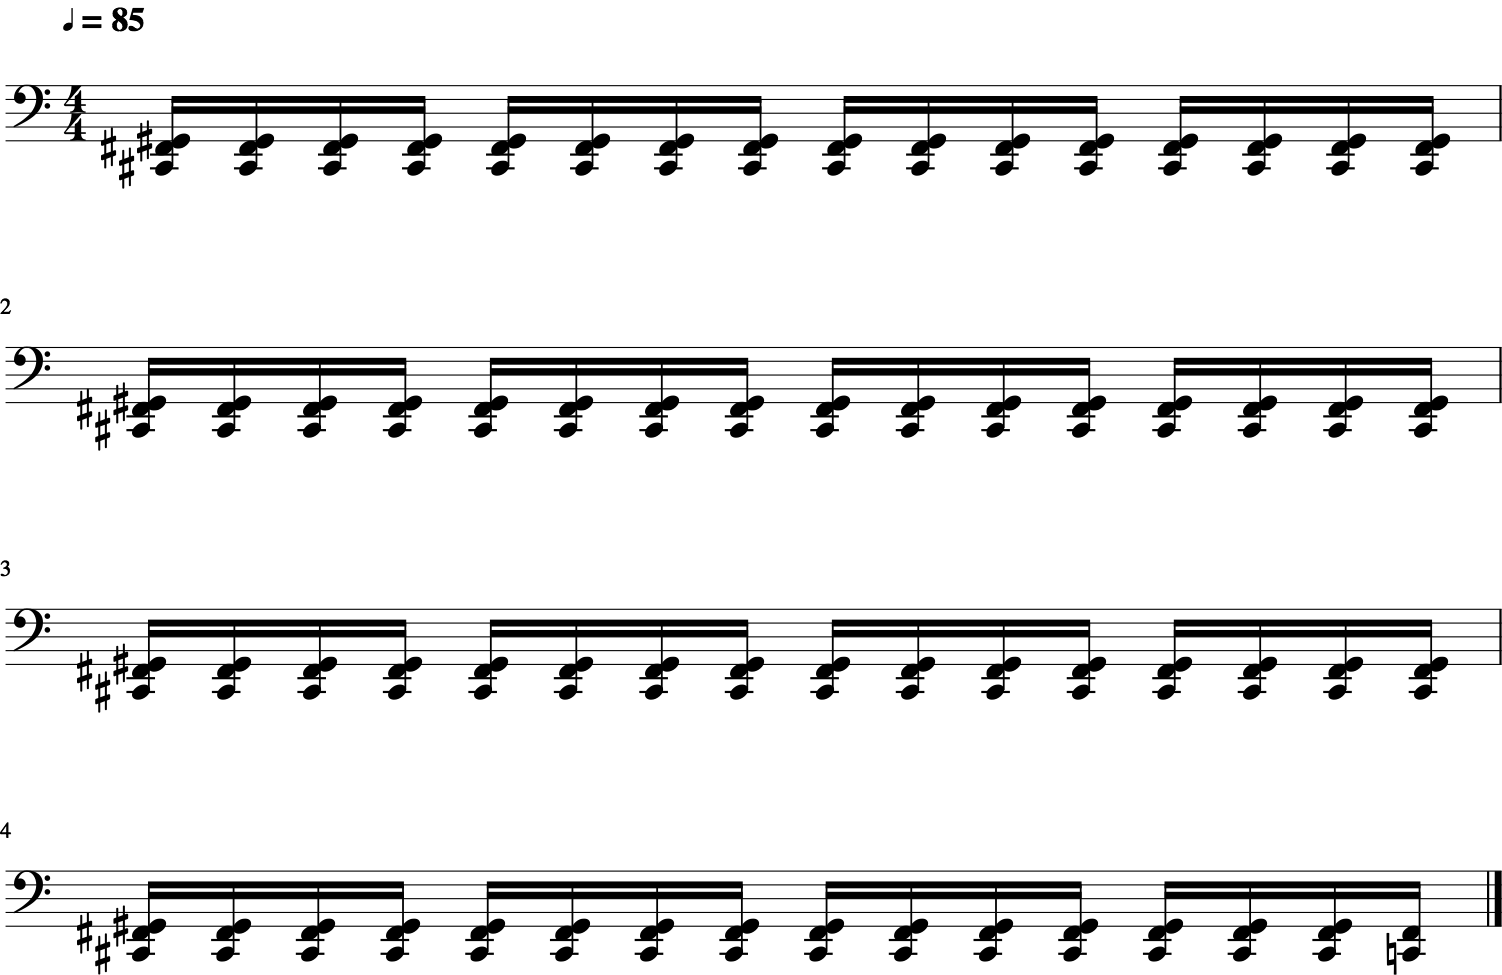

test_seq_1.mid


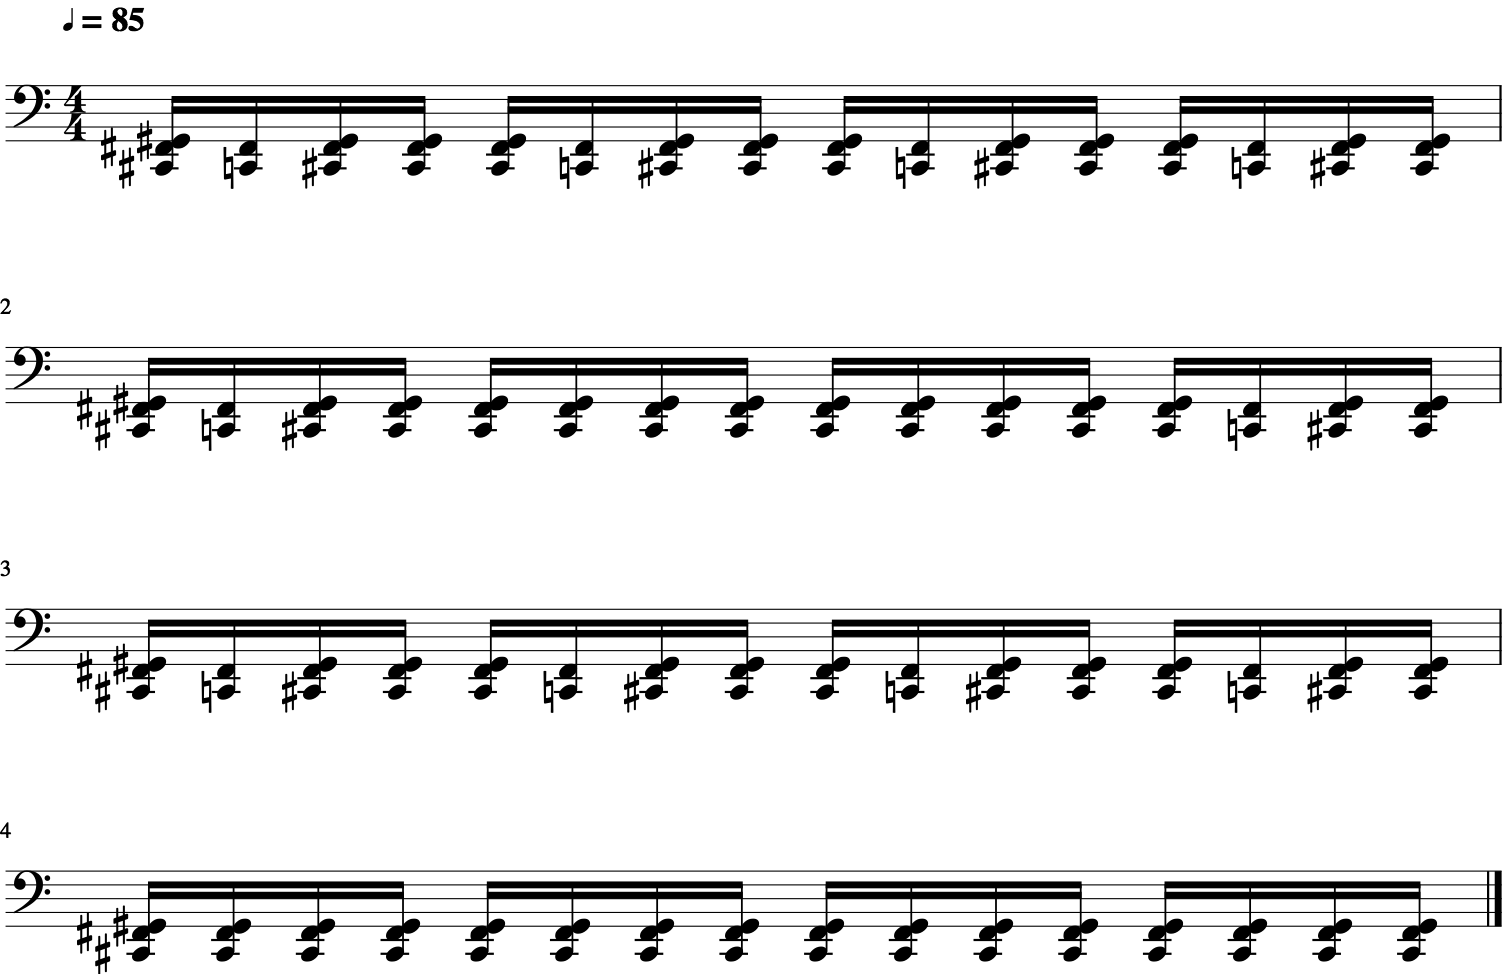

test_seq_2.mid


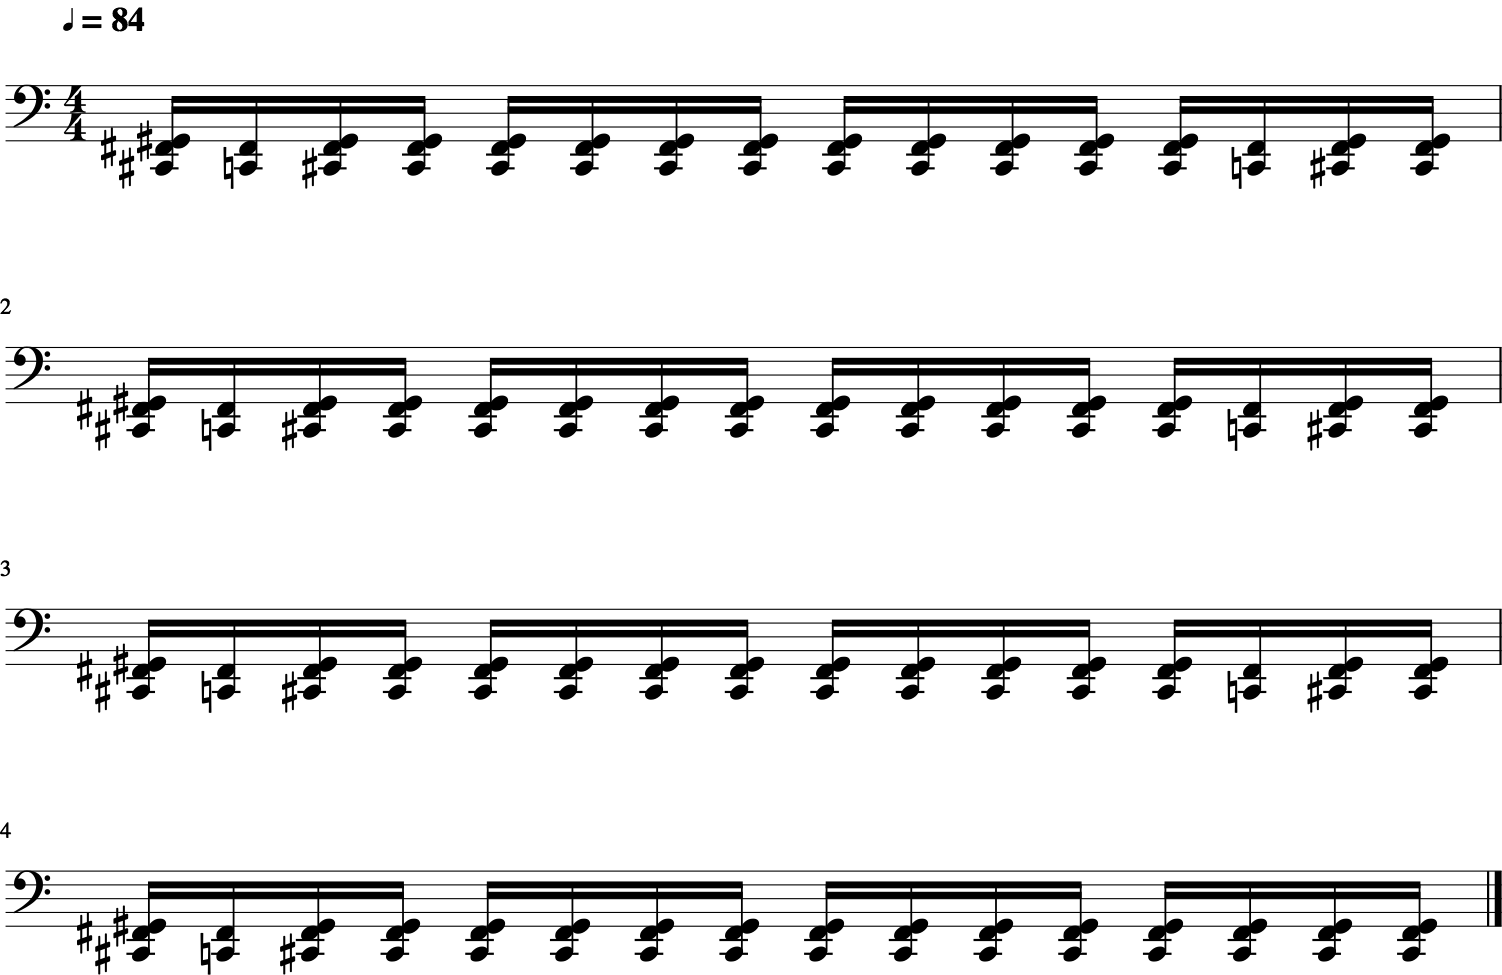

test_seq_3.mid


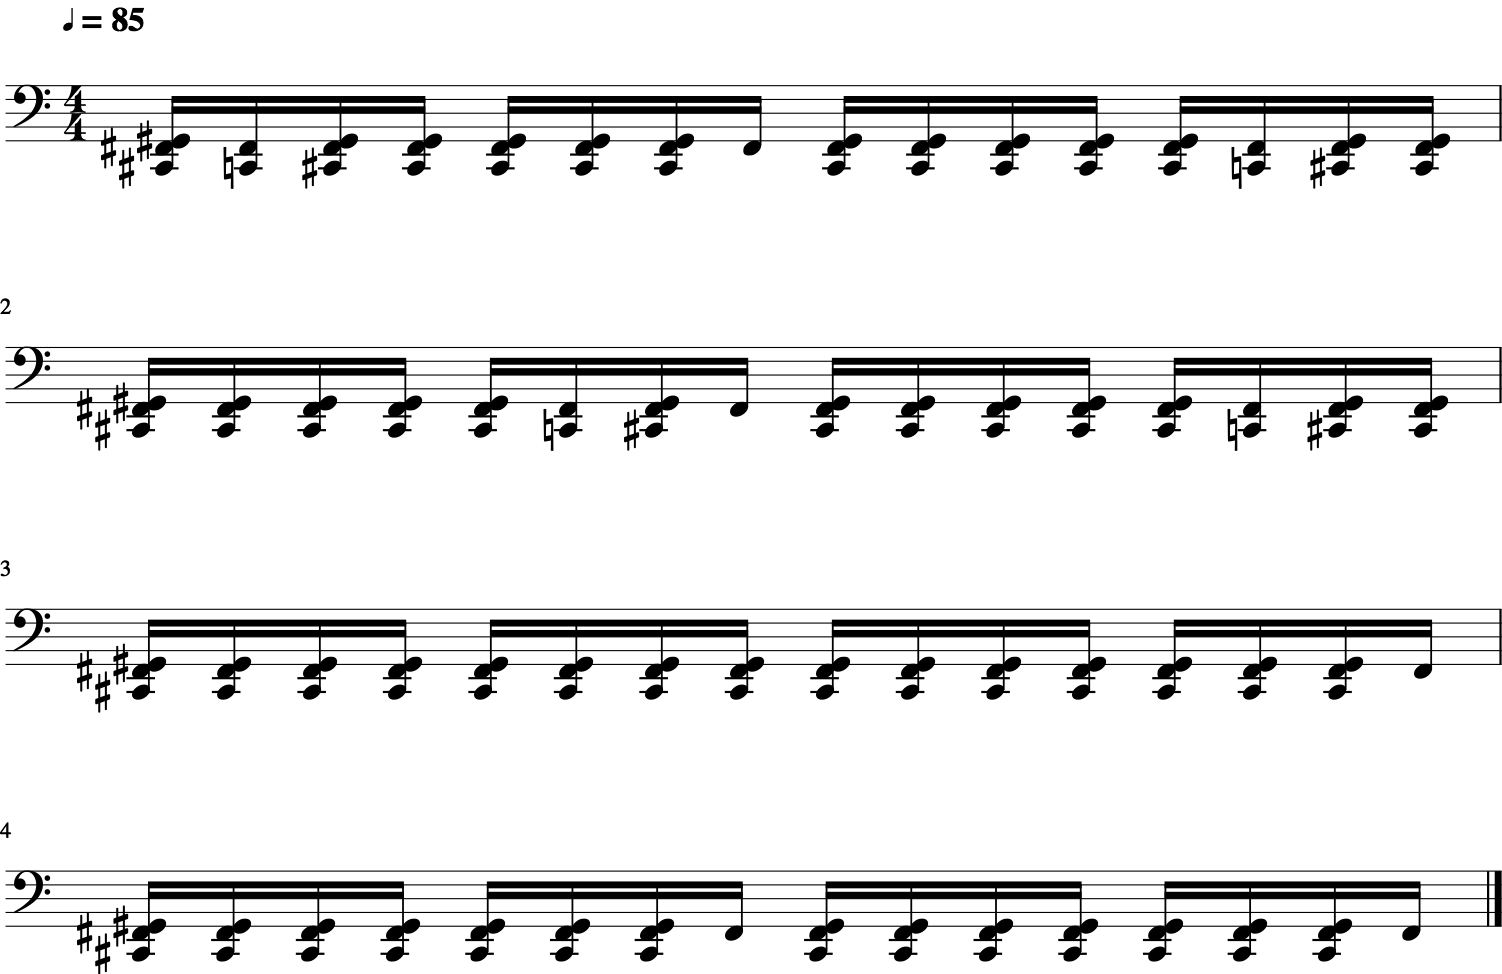

test_seq_4.mid


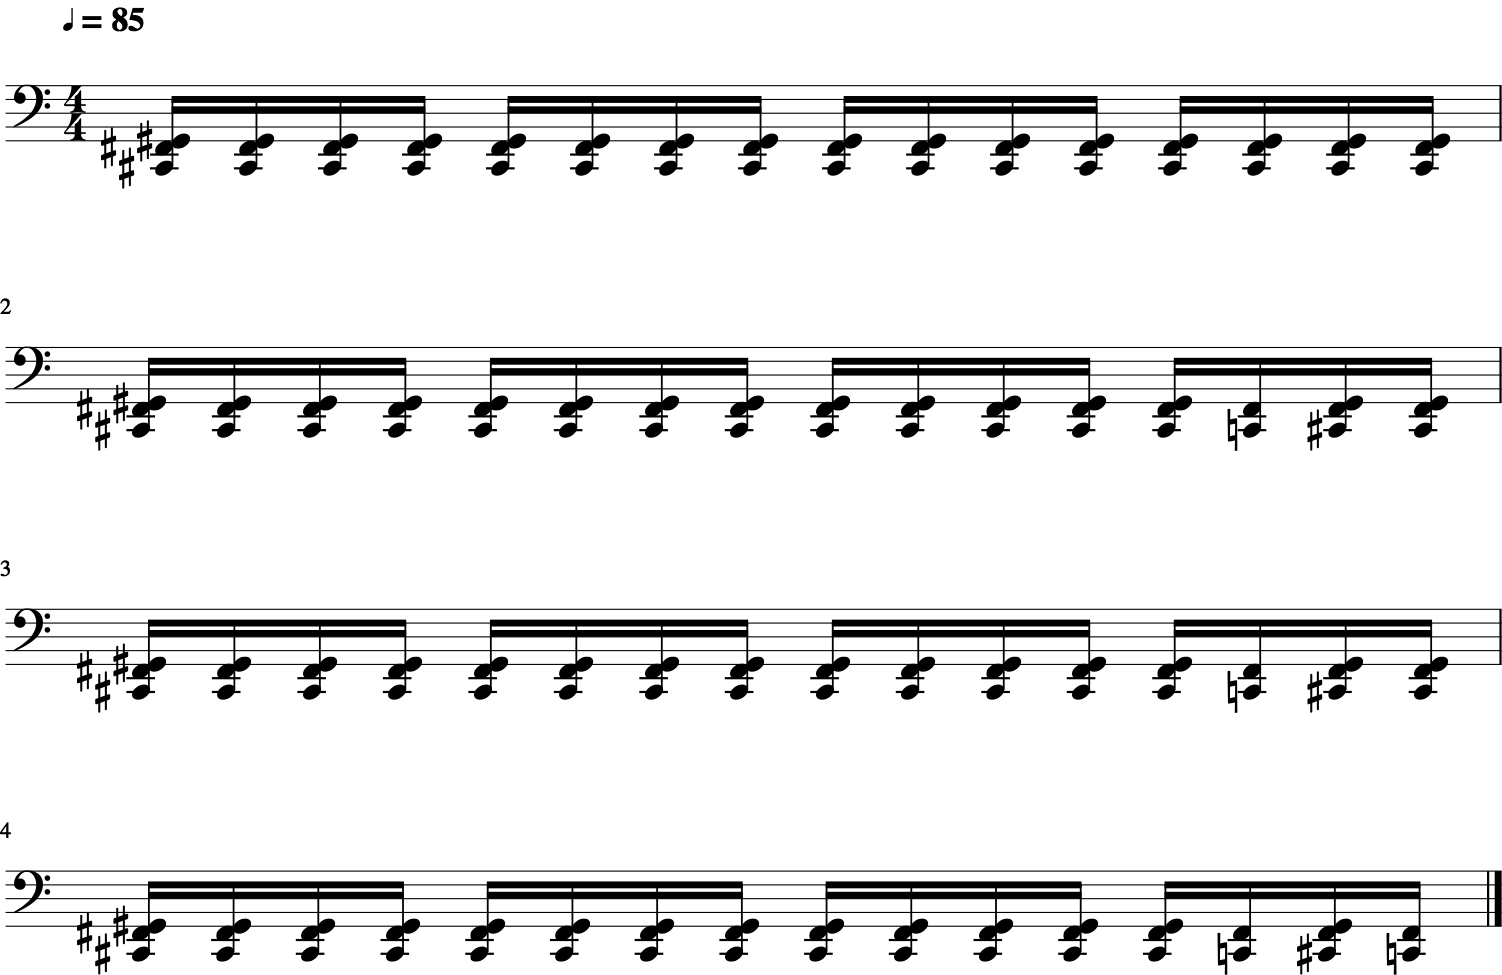

test_seq_5.mid


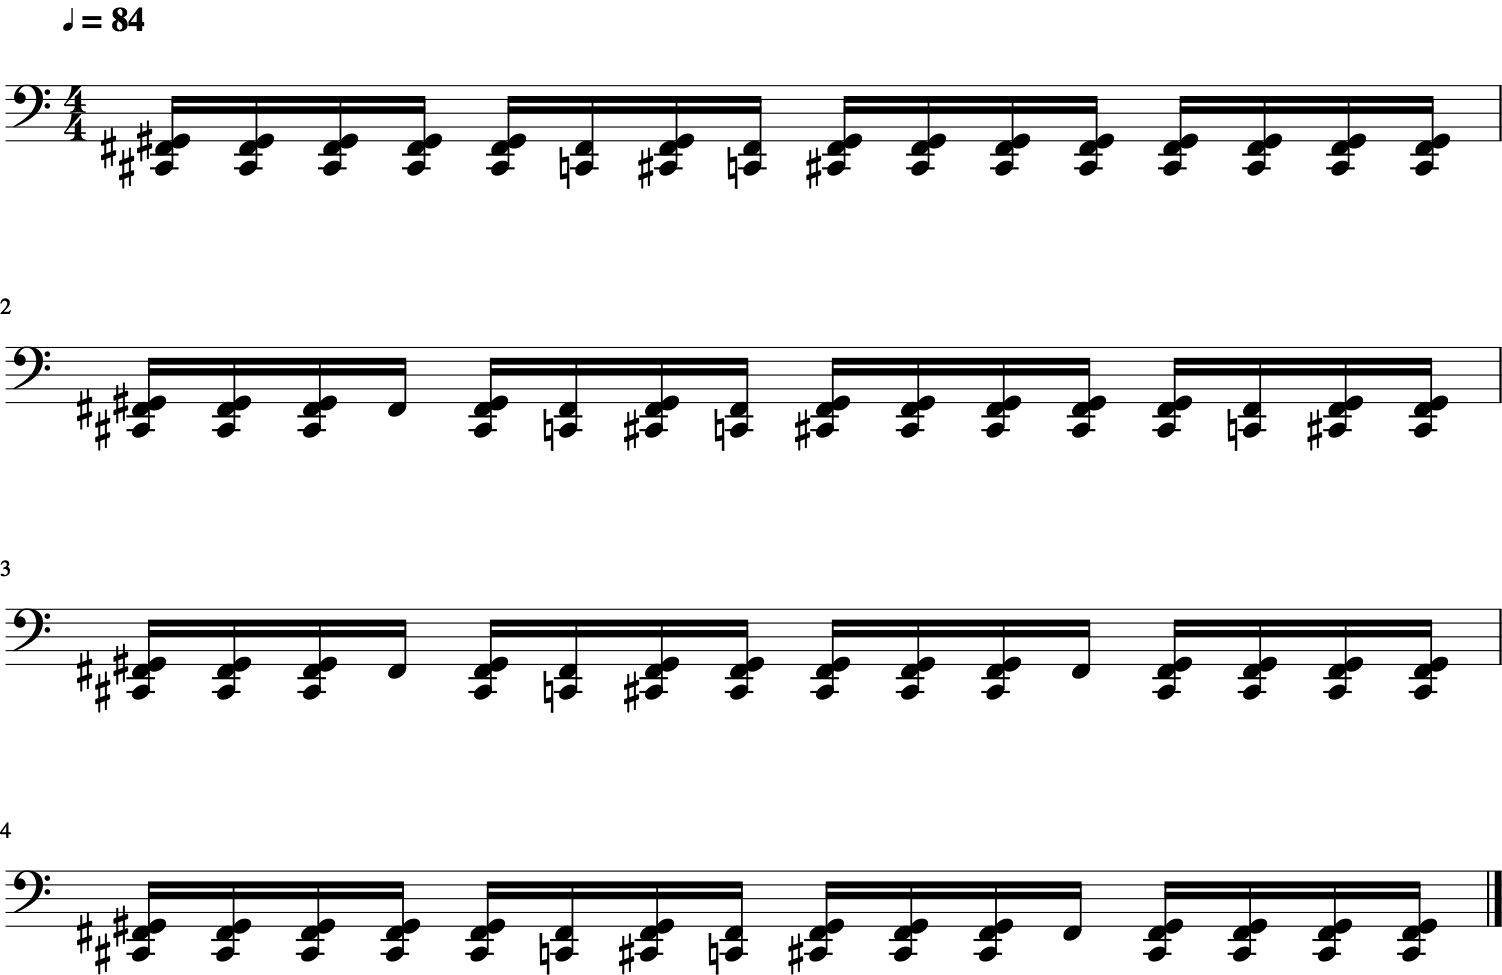

test_seq_6.mid


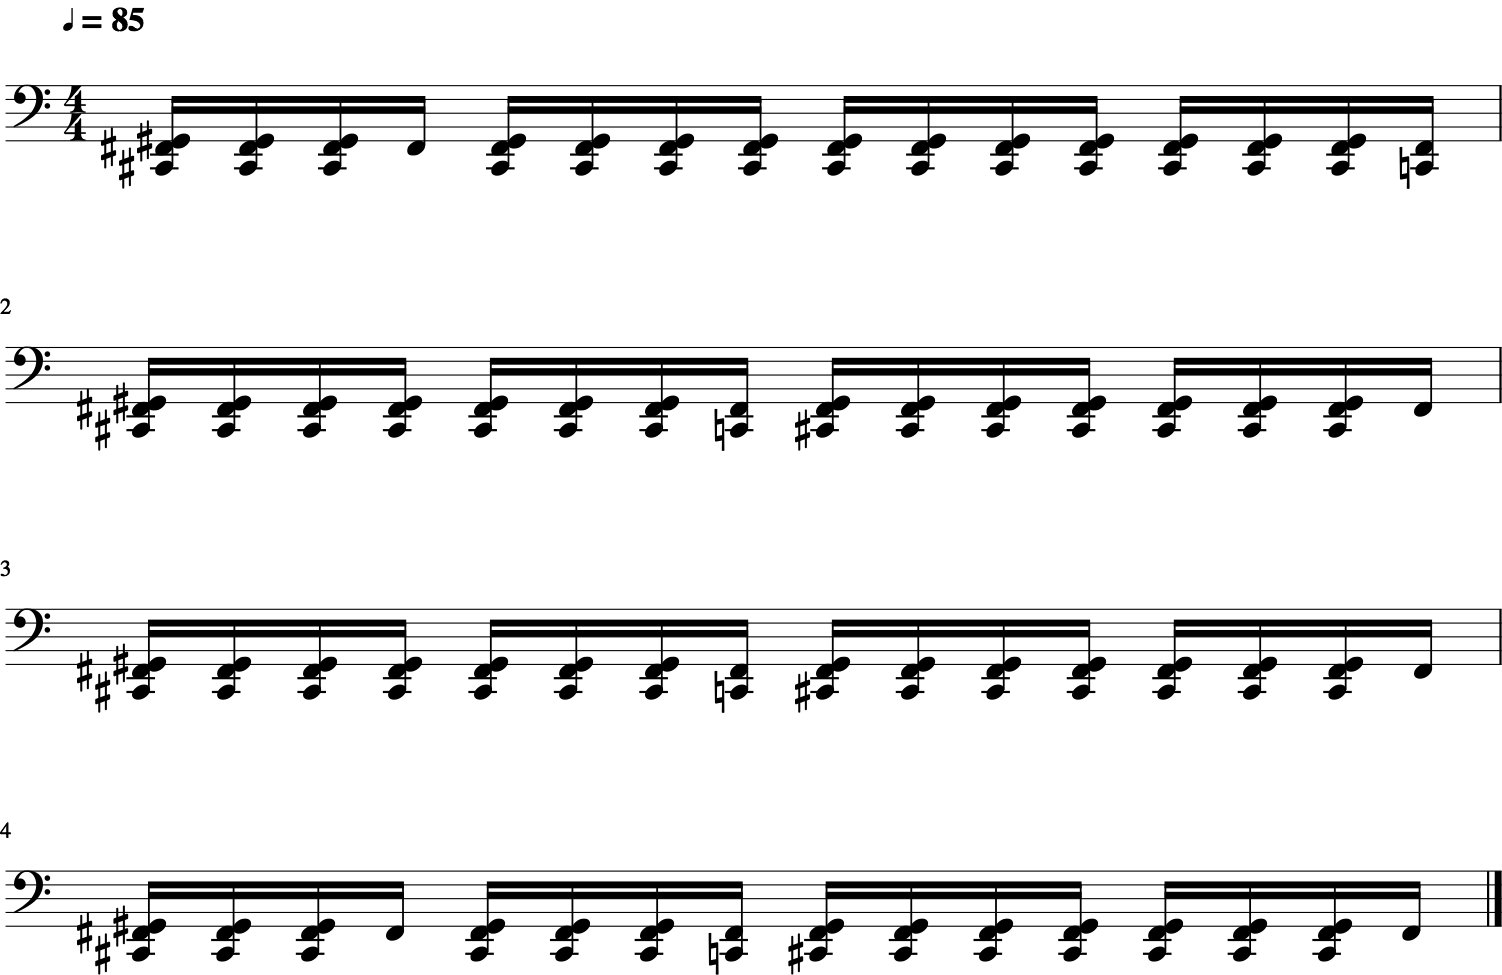

test_seq_7.mid


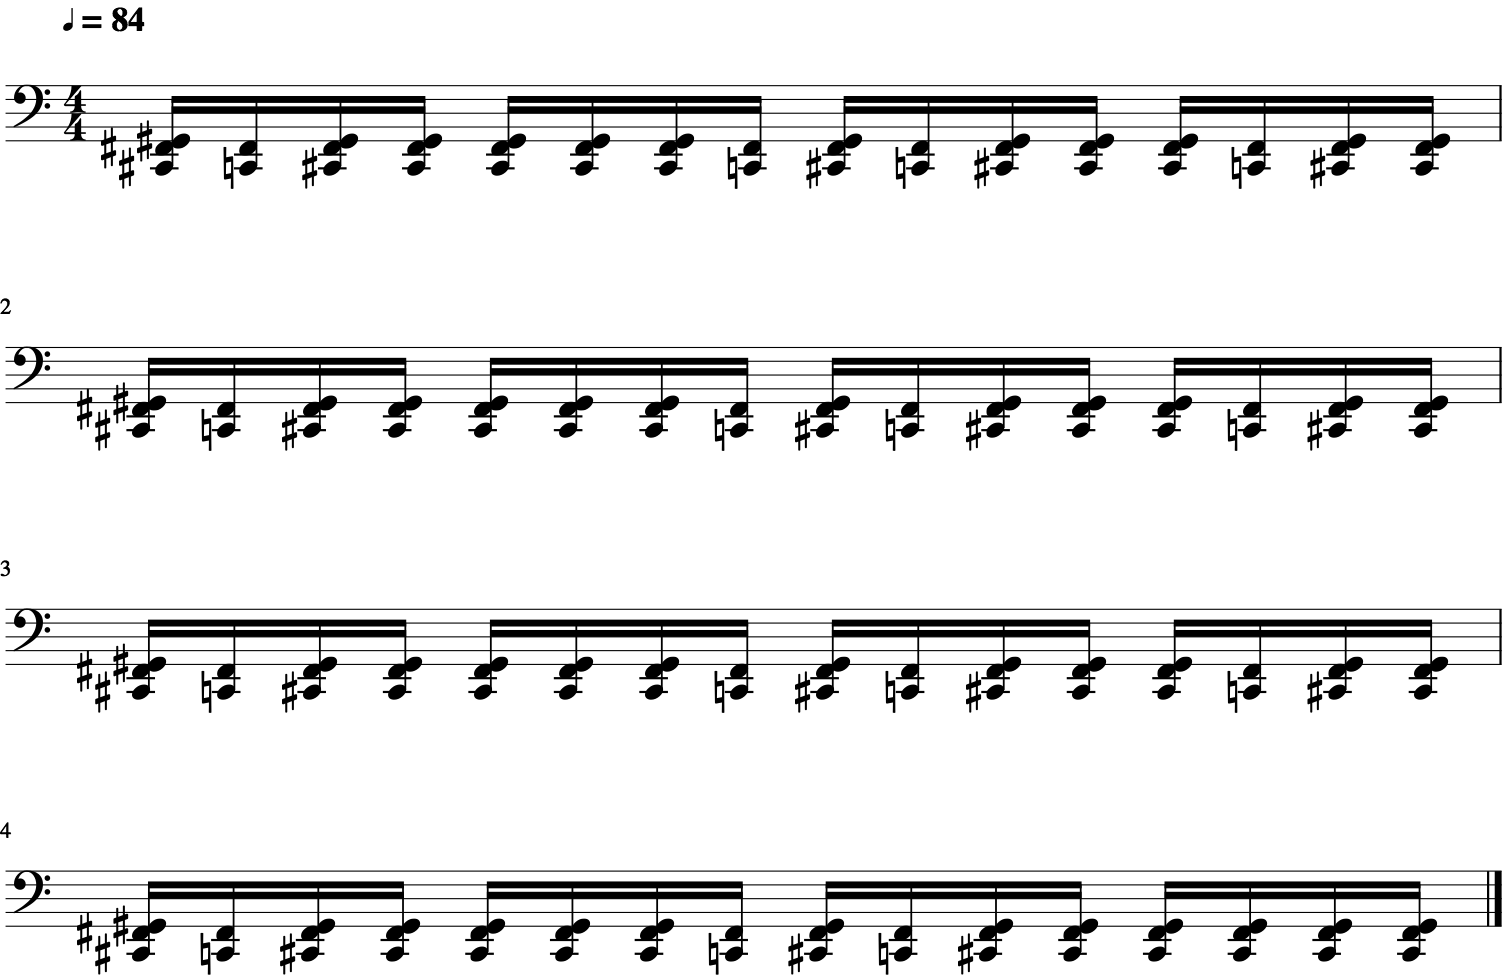

test_seq_8.mid


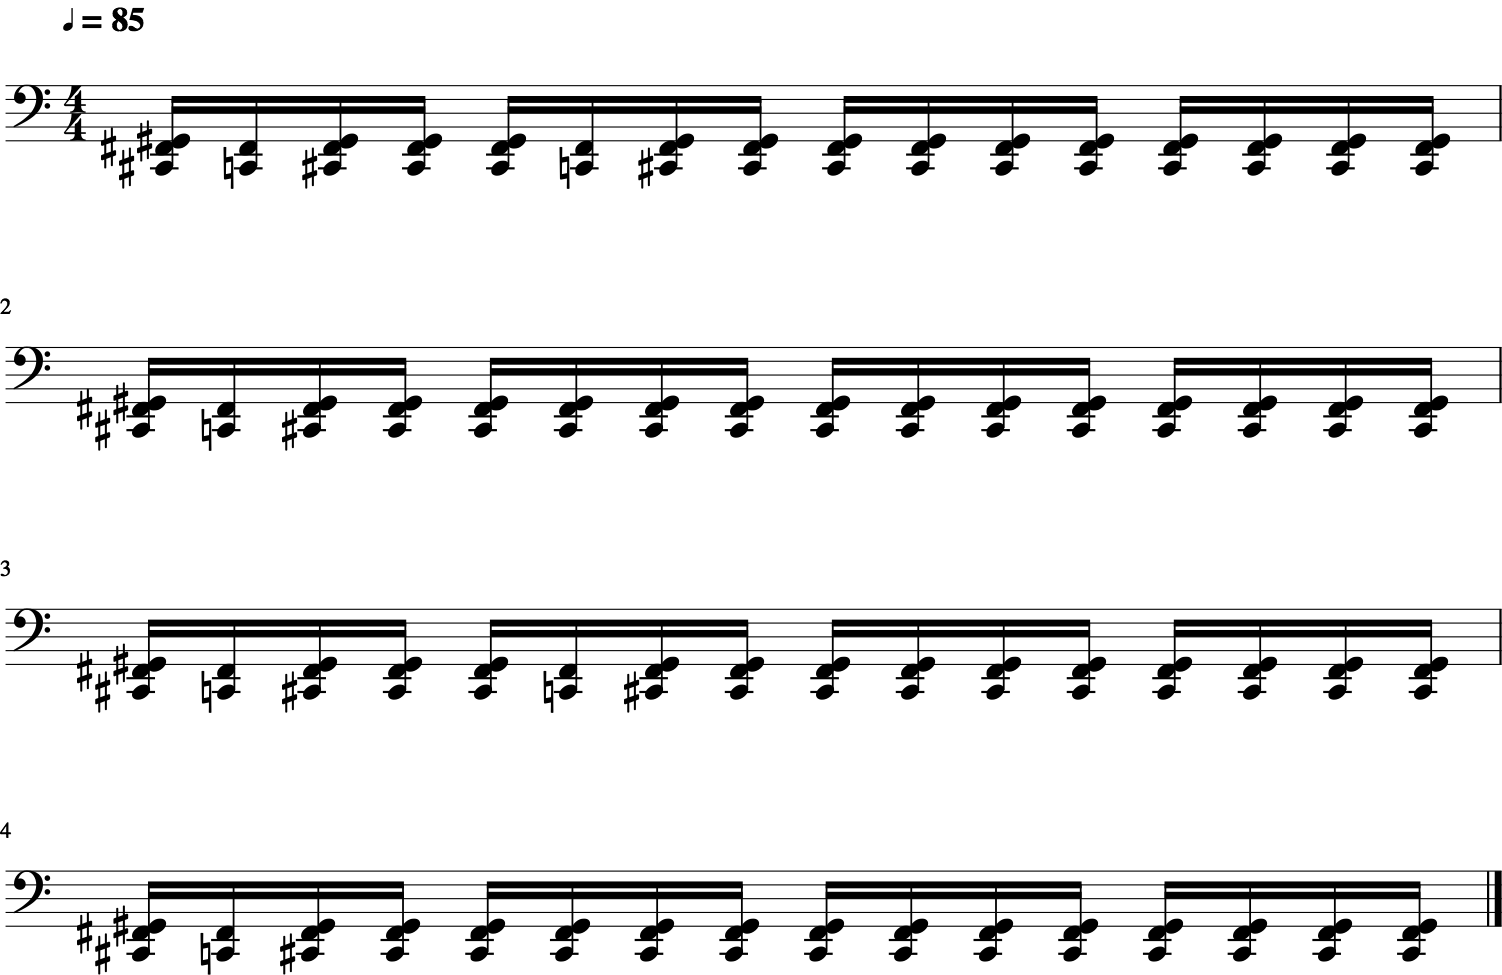

test_seq_9.mid


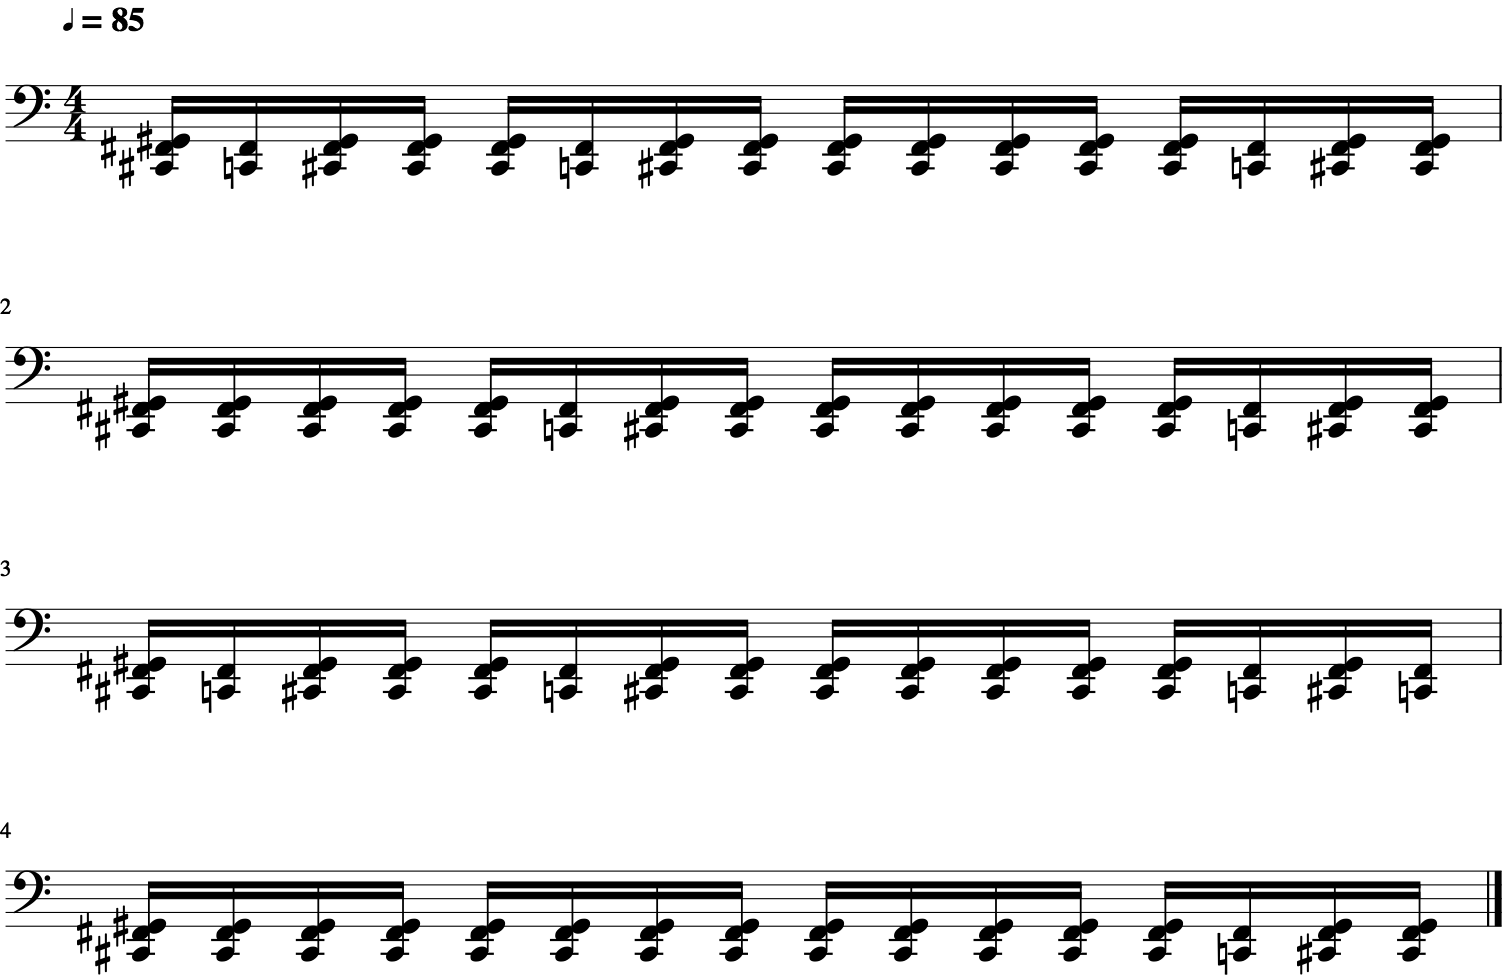

In [6]:
sequence_generator = SequenceGenerator(data_loader, sequence_model)
length = 64

for seq_index, seed in enumerate(seed_sequences):
    generated_seq_df = sequence_generator.generate(seed, length)
    writer = MidiWriter(note_mapper)
    # TODO, output to path of saved model
    # TODO start incrementing at last index
    save_to_path = "test_seq_" + str(seq_index) + ".mid"
    writer.convert_to_midi(generated_seq_df, save_to_path)
    print(save_to_path)
    mid = converter.parse(save_to_path)
    mid.measures(0, 8).show()